In [8]:
from hera_sim import DATA_PATH
from hera_sim.visibilities import VisCPU, ModelData, VisibilitySimulation
from pyradiosky import SkyModel
from astropy.coordinates import Longitude, Latitude
from astropy import units as u
from astropy.utils.data import import_file_to_cache
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
from pyuvsim.simsetup import initialize_uvdata_from_params, _complete_uvdata
from pyuvsim import BeamList
from pyradiosky import SkyModel
from hera_sim.beams import PolyBeam
import pyuvsim

import_file_to_cache("https://zenodo.org/record/3835582/files/gsm_components.h5?download=1", "/home/shashank/astro/pygdsm_files/gsm_components.h5", remove_original=False, pkgname='astropy', replace=True)
import_file_to_cache("https://zenodo.org/record/3835582/files/gsm2016_components.h5?download=1", "/home/shashank/astro/pygdsm_files/gsm2016_components.h5", remove_original=False, pkgname='astropy', replace=True)
import_file_to_cache("https://zenodo.org/record/3835582/files/gsm_fortran_test_data.h5?download=1", "/home/shashank/astro/pygdsm_files/gsm_fortran_test_data.h5", remove_original=False, pkgname='astropy', replace=True)
import_file_to_cache("https://zenodo.org/record/3835582/files/lfsm.h5?download=1", "/home/shashank/astro/pygdsm_files/lfsm.h5", remove_original=False, pkgname='astropy', replace=True)
import_file_to_cache("https://lambda.gsfc.nasa.gov/data/foregrounds/haslam_2014/haslam408_dsds_Remazeilles2014.fits", "/home/shashank/astro/pygdsm_files/haslam408_dsds_Remazeilles2014.fits", remove_original=False, pkgname='astropy', replace=True)
from pygdsm import GlobalSkyModel

In [9]:
config_file = (
    DATA_PATH / 
    'tutorials_data/visibility_simulator/obsparam_hera_phase1_gleam_top50.yaml'
).as_posix()

uvdata, _, beam_ids = initialize_uvdata_from_params(config_file)
_complete_uvdata(uvdata, inplace=True)

Cannot check consistency of a string-mode BeamList! Set force=True to force consistency checking.


In [10]:
uvdata.freq_array

array([1.00000000e+08, 1.00097656e+08, 1.00195312e+08, 1.00292969e+08,
       1.00390625e+08, 1.00488281e+08, 1.00585938e+08, 1.00683594e+08,
       1.00781250e+08, 1.00878906e+08])

In [11]:
np.save('freqs.npy', uvdata.freq_array)

In [14]:
pairs=uvdata.get_antpairs()

In [15]:
np.save('baselines.npy', uvdata.get_antpairs())

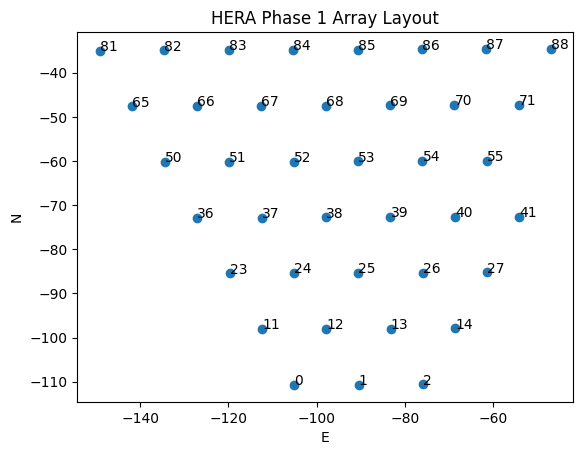

In [16]:
antpos, antnum = uvdata.get_ENU_antpos()

# Plot the EN antenna position.
plt.scatter(antpos[:, 0], antpos[:, 1])
for i, antnum in enumerate(uvdata.antenna_numbers):
    plt.text(antpos[i, 0], antpos[i, 1], antnum)
plt.title('HERA Phase 1 Array Layout')
plt.xlabel('E')
plt.ylabel('N')
plt.show()

# GSM Model generation

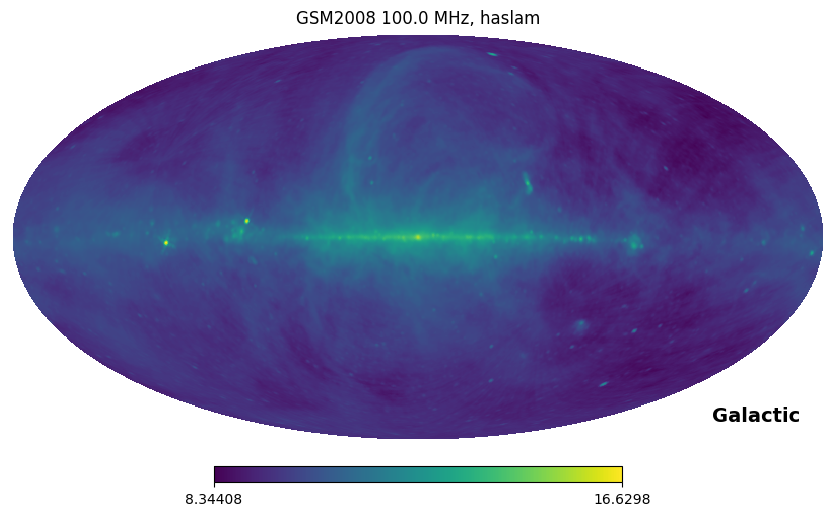

In [17]:
gsm = GlobalSkyModel()
gsm_map = gsm.generate(uvdata.freq_array[0] / 1.e6) # freqs in MHz
gsm.view(logged=True)
#gsm.write_fits("gsm_100MHz_10freqs.fits")
np.save("gsm_map_100MHz.npy", gsm_map)

In [18]:
nside_out = 64
gsm_map_load = np.load("gsm_map_100MHz.npy")
gsm_map_down = hp.ud_grade(gsm_map_load, nside_out=nside_out)
gsm_map_load.shape, gsm_map_down.shape

((3145728,), (49152,))

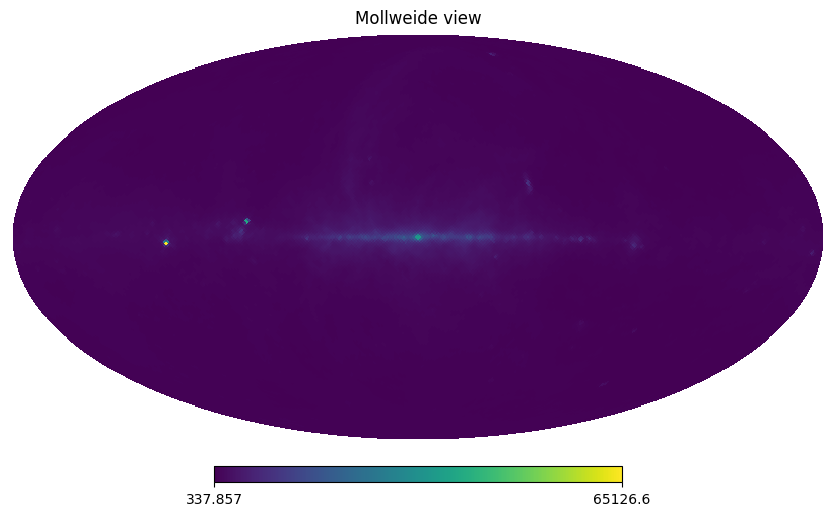

In [19]:
hp.mollview(gsm_map_down)

In [20]:
# Create a diffuse HEALPix SkyModel with a GSM sky and flat spectra.
component_type = 'healpix'
nside = nside_out
npix = 12 * nside ** 2
hpx_order = 'ring'
hpx_inds = np.arange(npix)

spectral_type = 'flat'

stokes = np.zeros((4, 1, npix)) * u.K

stokes[0,:,:] = gsm_map_down * u.K

diffuse_params = {
    'component_type': component_type,
    'nside': nside,
    'hpx_inds': hpx_inds,
    'hpx_order': hpx_order,
    'spectral_type' : spectral_type,
    'stokes': stokes,
    'history': ' Create a diffuse GSM sky with a flat spectra.\n'
}
diffuse_model = SkyModel(**diffuse_params)
print('SkyModel History:\n', diffuse_model.history)
print('Type of sky model:', diffuse_model.component_type)
print('Nside:', diffuse_model.nside)
print('Number of components = number of healpix pixels:', 
      diffuse_model.Ncomponents)

SkyModel History:
  Create a diffuse GSM sky with a flat spectra.
  Read/written with pyradiosky version: 0.1.3.
Type of sky model: healpix
Nside: 64
Number of components = number of healpix pixels: 49152


In [21]:
frequencies = uvdata.freq_array * u.Hz
diffuse_model_full = diffuse_model.at_frequencies(frequencies, inplace=False)

# VisCPU

In [22]:
# Define a function to run the simulation.
def run_simulation(sky_model):
    """Create and run a simulation given a sky model."""
    # Use the same config file as in Example 1 to initialize UVdata and beams.
    uvdata, beams, beam_ids = initialize_uvdata_from_params(config_file)
    _complete_uvdata(uvdata, inplace=True)
    
    # Initialize ModelData given the SkyModel
    data_model = ModelData(uvdata=uvdata, sky_model=sky_model, beams=beams, beam_ids=beam_ids)

    # Initialize a VisibilitySimulation instance, using VisCPU
    simulation = VisibilitySimulation(
        data_model=data_model,
        simulator=VisCPU()
    )
    _  = simulation.simulate()
    
    return simulation

diffuse_sim = run_simulation(diffuse_model_full)

Cannot check consistency of a string-mode BeamList! Set force=True to force consistency checking.


In [23]:
len(uvdata.get_antpairs())

780

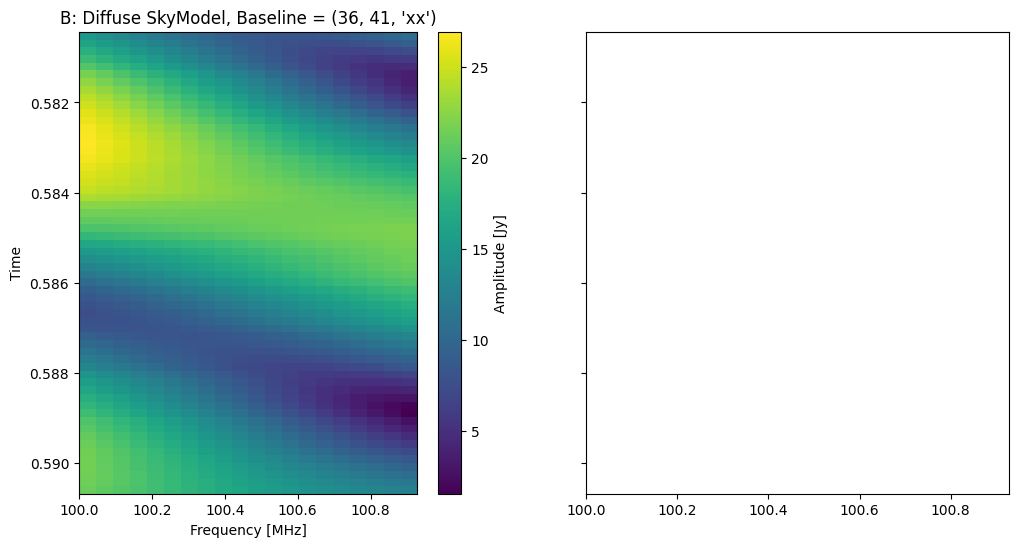

In [24]:
bls = (36, 41, 'xx')
# Define some labels for all the cases that we want to compare
waterfall_labels = ['B: Diffuse SkyModel, Baseline = {}'.format(bls)]

# Get waterfalls of the complex visibility, 
# same baseline (0, 1, 'xx') as in Example 1.
waterfall_list = [sim.data_model.uvdata.get_data(bls) for sim in [diffuse_sim]]

#Make A + B, and C - (A + B), add them to the list
#waterfall_list.append(waterfall_list[0] + waterfall_list[1])
#waterfall_list.append(waterfall_list[2] - waterfall_list[3])

# Extent for the waterfall plot, same for all three simulations
extent = [diffuse_sim.uvdata.freq_array[0, 0] / 1e6, 
          diffuse_sim.uvdata.freq_array[0, -1] / 1e6, 
          diffuse_sim.uvdata.time_array[-1] - 2458101, 
          diffuse_sim.uvdata.time_array[0] - 2458101]

# Plotting
fig, ax = plt.subplots(1, 2, sharex='all', sharey='all', figsize=(12, 6))
for i, waterfall in enumerate(waterfall_list):
    im = ax[i].imshow(np.abs(waterfall), aspect='auto', interpolation='none', extent=extent)
    fig.colorbar(im, ax=ax[i], label='Amplitude [Jy]')
    ax[i].set_title(waterfall_labels[i]) 
    ax[i].set_ylabel('JD - 2458101')
    
ax[0].set_ylabel('Time')
ax[0].set_xlabel('Frequency [MHz]')
fig.subplots_adjust(hspace=0.3)

#plt.savefig('plot.pdf')hb

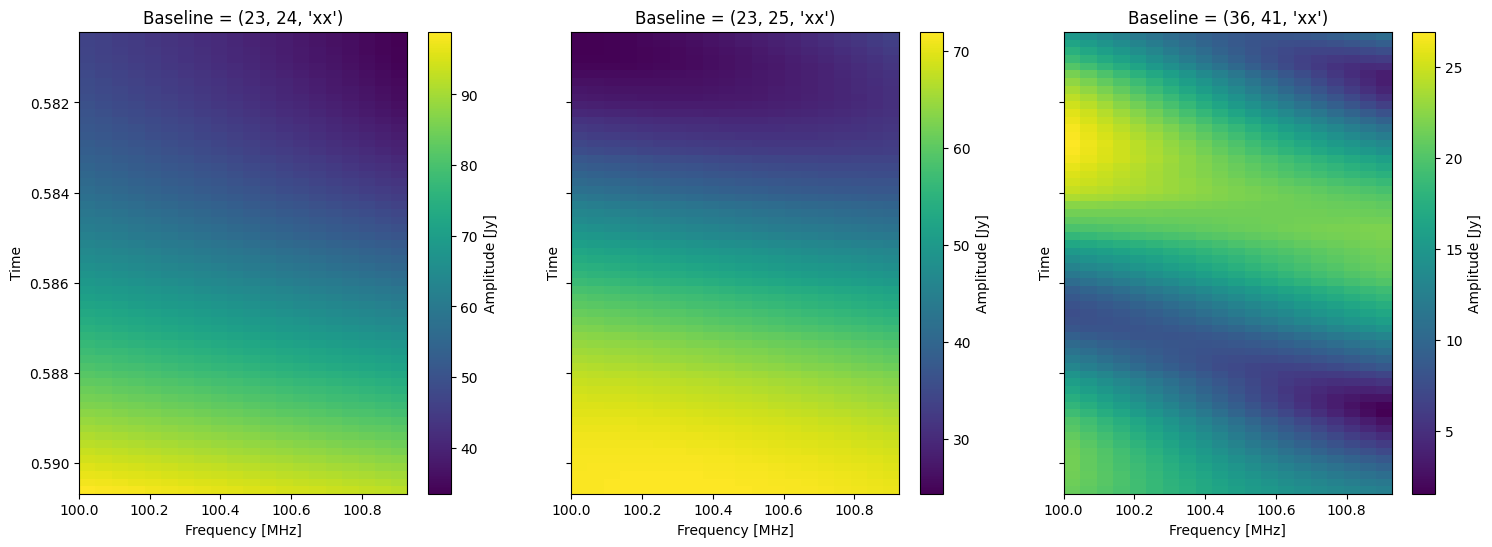

In [25]:
blslist=[(23, 24, 'xx'), (23, 25, 'xx'), (36, 41, 'xx')]
total_bls_list = [(x, y, 'xx') for (x, y) in uvdata.get_antpairs()]
# Define some labels for all the cases that we want to compare
waterfall_labels = ['Baseline = {}'.format(bl) for bl in blslist]

# Get waterfalls of the complex visibility, 
# same baseline (0, 1, 'xx') as in Example 1.
#waterfall_list = [sim.data_model.uvdata.get_data(bls) for sim in [diffuse_sim]]
waterfall_list = [diffuse_sim.data_model.uvdata.get_data(bl) for bl in blslist]

#Make A + B, and C - (A + B), add them to the list
#waterfall_list.append(waterfall_list[0] + waterfall_list[1])
#waterfall_list.append(waterfall_list[2] - waterfall_list[3])

# Extent for the waterfall plot, same for all three simulations
extent = [diffuse_sim.uvdata.freq_array[0, 0] / 1e6, 
          diffuse_sim.uvdata.freq_array[0, -1] / 1e6, 
          diffuse_sim.uvdata.time_array[-1] - 2458101, 
          diffuse_sim.uvdata.time_array[0] - 2458101]

# Plotting
fig, ax = plt.subplots(1, 3, sharex='all', sharey='all', figsize=(18, 6))
for i, waterfall in enumerate(waterfall_list):
    im = ax[i].imshow(np.abs(waterfall), aspect='auto', interpolation='none', extent=extent)
    fig.colorbar(im, ax=ax[i], label='Amplitude [Jy]')
    ax[i].set_title(waterfall_labels[i])
    ax[i].set_ylabel('Time')
    ax[i].set_xlabel('Frequency [MHz]') 
    #ax[i].set_ylabel('JD - 2458101')
    
fig.subplots_adjust(hspace=0.3)
#plt.savefig('plot.pdf')hb

In [26]:
vis = [diffuse_sim.uvdata.get_data(bl) for bl in blslist]
len(vis)
vis[0].shape

(60, 20)

Casting complex values to real discards the imaginary part


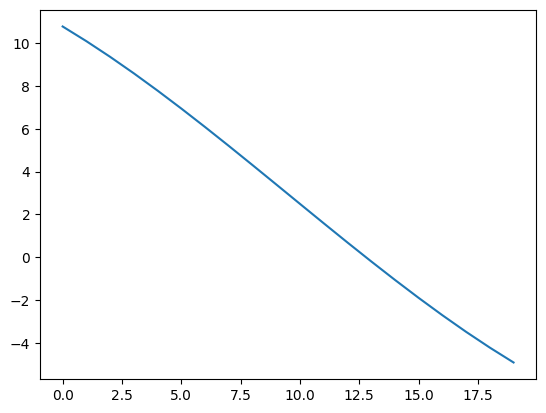

In [27]:
plt.plot(vis[2][0,:])

In [28]:
total_bls_list = [(x, y, 'xx') for (x, y) in uvdata.get_antpairs()]
total_waterfall_labels = ['Baseline = {}'.format(bl) for bl in total_bls_list]

In [29]:
total_vis = [diffuse_sim.uvdata.get_data(bl) for bl in total_bls_list]
np.save('total_visibilities_viscpu_{}.npy'.format(nside),total_vis)

# UVSim

In [30]:
uvdata1, beams1, beam_ids1 = initialize_uvdata_from_params(config_file)

Cannot check consistency of a string-mode BeamList! Set force=True to force consistency checking.


In [ ]:
uvdata = pyuvsim.uvsim.run_uvdata_uvsim(input_uv=uvdata1, beam_list=beams1, beam_dict=beam_ids1, 
                           catalog=pyuvsim.simsetup.SkyModelData(diffuse_model_full), quiet=False)

In [32]:
vis1 = [uvdata.get_data(bl) for bl in blslist]
vis2 = [uvdata.get_data(bl) for bl in total_bls_list]
np.save("total_visibilities_pyuvsim_{}.npy".format(nside), vis2)

In [33]:
pairs=uvdata.get_ENU_antpos()

In [39]:
n=772

Text(0.5, 1.0, "Visibility vs Frequency for Baseline = (88, 81, 'xx')")

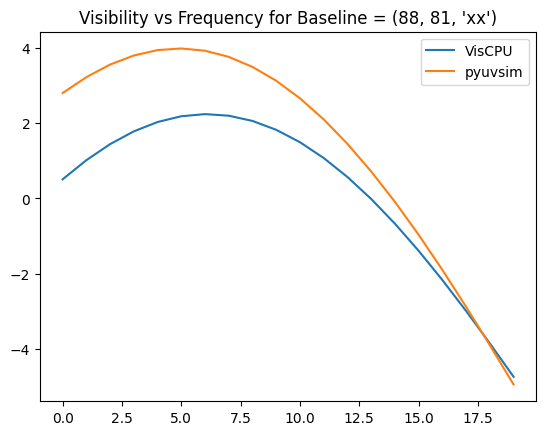

In [40]:
plt.plot(total_vis[n][0,:],label='VisCPU')
plt.plot(vis2[n][0,:],label='pyuvsim')
plt.legend()
plt.title('Visibility vs Frequency for '+total_waterfall_labels[n])

Text(0.5, 1.0, "% error vs frequency for Baseline = (88, 81, 'xx')")

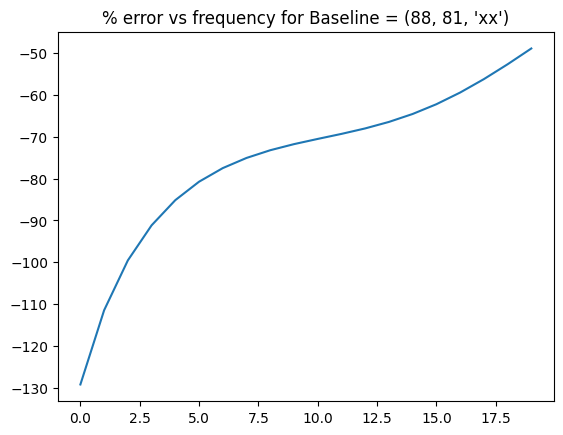

In [41]:
plt.plot((total_vis[n][0,:] - vis2[n][0,:]) * 100. / vis2[n][0,:])
plt.title('% error vs frequency for '+total_waterfall_labels[n])

Text(0.5, 1.0, "Visibility vs Time for Baseline = (88, 81, 'xx')")

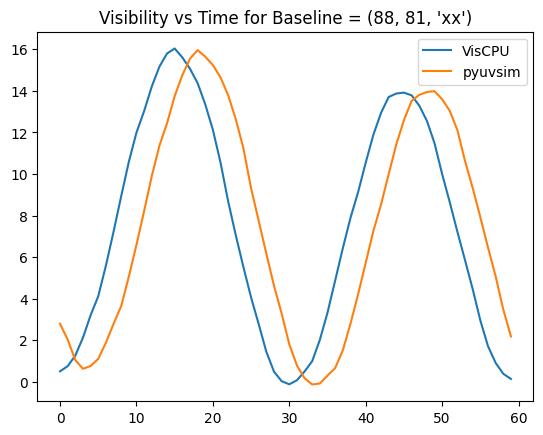

In [42]:
plt.plot(total_vis[n][:,0],label='VisCPU')
plt.plot(vis2[n][:,0],label='pyuvsim')
plt.legend()
plt.title('Visibility vs Time for '+total_waterfall_labels[n])

Text(0.5, 1.0, "% error vs time for Baseline = (88, 81, 'xx')")

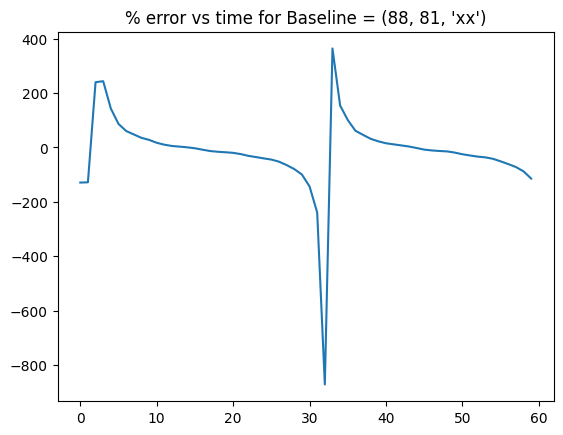

In [43]:
plt.plot((total_vis[n][:,0] - vis2[n][:,0]) * 100. / vis2[n][:,0])
plt.title('% error vs time for '+total_waterfall_labels[n])